#### Importar librerias


In [15]:
# Manipuladcion de datos 
import pandas as pd 
import numpy as np
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

#libreria para descargar datos de productos financieros
import yfinance as yf 

# Calculo de indicadores tecnicos 'ta package' 
import ta as ta  
from ta.momentum import RSIIndicator, StochasticOscillator,AwesomeOscillatorIndicator
from ta.trend import MACD, ADXIndicator,IchimokuIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.trend import SMAIndicator, EMAIndicator




[enlace a Documentacion libreria TA]: https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html
[**Visita la documentación libreria TA** ][enlace a Documentacion libreria TA]

#### Extraccion de datos OHLCV (Open,High,Low,Close,Volume) del ticket definido 
- Elegimos Tickets
- Funcion extract_clean_ticker() para crear el dataset inicial y tener los datos historicos. 

In [16]:
# Definimos los tickets 
vandguard_sp500 = 'VOO'


In [ ]:
def extract_clean_ticker(ticker: str, start=None, end=None, interval=None) -> pd.DataFrame:
    """
    Descarga y limpia datos históricos de un ticker con yfinance y genera todo el dataframe que se utilizara para analizar el stock. 
    
    Args:
        ticker (str): Símbolo del ticker (ej: 'VOO', '^GSPC')
        start (str): Fecha de inicio 'YYYY-MM-DD'
        end (str): Fecha de fin 'YYYY-MM-DD'
        interval (str): Intervalo temporal ('1d', '1wk', '1h', etc.)
        
    Returns:
        pd.DataFrame: DataFrame limpio con columnas estandarizadas.
    """
    df = yf.download(
        tickers=ticker,
        start=start,
        end=end,
        interval=interval,
        auto_adjust=True,
        progress=False
    )

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1)

    df = df.reset_index()

    # Detectar automáticamente la columna de fecha
    date_col = None
    for col in df.columns:
        if 'date' in col.lower() or 'time' in col.lower():
            date_col = col
            break
    if date_col is None:
        raise ValueError(f"No se encontró columna de fecha en {ticker}")

    df.rename(columns={date_col: "date"}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.tz_localize(None)
    df.columns = [col.lower() for col in df.columns]
    df = df.sort_values('date')
    df = df.round(3)

    cols_esperadas = {'open', 'high', 'low', 'close', 'volume'}
    if not cols_esperadas.issubset(df.columns):
        raise ValueError(f"Faltan columnas necesarias en {ticker}: {cols_esperadas - set(df.columns)}")

    return df

In [18]:

df_voo = extract_clean_ticker(vandguard_sp500, start='2010-01-01', end='2025-06-01', interval='1d')

df_voo['date'] = pd.to_datetime(df_voo['date'])


#### Agregar indicadores tecnicos al dataframe

In [ ]:

def añadir_indicadores_tecnicos(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula e incorpora indicadores técnicos  y divergencias 
    al DataFrame de precios OHLCV para análisis diario.
    
    Parámetros:
    -----------
    df : pd.DataFrame
        Dataframe con columnas 'open', 'high', 'low', 'close', 'volume'.
    
    Retorna:
    --------
    pd.DataFrame
        DataFrame con columnas adicionales para cada indicador y divergencias.
    
    Indicadores incluidos:
    ---------------------
    - RSI (Relative Strength Index) : fuerza relativa de precios.
    - MACD : tendencia y momentum; columnas macd, macd_signal, macd_diff.
    - Estocástico (%K, %D) : sobrecompra/sobreventa.
    - Bandas de Bollinger : volatilidad y niveles de soporte/resistencia dinámicos.
    - ATR (Average True Range) : volatilidad real del mercado.
    - SMA y EMA : medias móviles simples y exponenciales.
    - ADX : fuerza de tendencia.
    
    """
    df = df.copy()
    df['daily_return'] = df['close'].pct_change()
    # RSI
    rsi = RSIIndicator(close=df['close'], window=14)
    df['rsi'] = rsi.rsi()  # Oscilador de fuerza relativa

    # MACD
    macd = MACD(close=df['close'])
    df['macd'] = macd.macd()  # Línea MACD
    df['macd_signal'] = macd.macd_signal()  # Línea de señal
    df['macd_diff'] = macd.macd_diff()  # Histograma MACD

    # Estocástico
    stoch = StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=14, smooth_window=3)
    df['stochastic_k'] = stoch.stoch()  # Línea %K
    df['stochastic_d'] = stoch.stoch_signal()  # Línea %D o linea de confirmacion

    # Bandas de Bollinger
    bb = BollingerBands(close=df['close'], window=20, window_dev=2)
    df['bollinger_hband'] = bb.bollinger_hband()  # Banda superior
    df['bollinger_lband'] = bb.bollinger_lband()  # Banda inferior
    df['bollinger_mavg'] = bb.bollinger_mavg()    # Media central
    df['bollinger_width'] = bb.bollinger_wband()  # Ancho de banda : valores entre hband - lband

    # ATR
    atr = AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=14)
    df['atr'] = atr.average_true_range()  # Medida de volatilidad

    # EMA
    df['ema_20'] = EMAIndicator(close=df['close'], window=20).ema_indicator()
    df['ema_50'] = EMAIndicator(close=df['close'], window=50).ema_indicator()
    df['ema_200'] = EMAIndicator(close=df['close'], window=200).ema_indicator()
    df['ema_9'] = EMAIndicator(close=df['close'], window=9).ema_indicator()
    
    
    # Ichimoku Cloud: identifica soporte, resistencia y tendencia
    ichimoku = IchimokuIndicator(high=df['high'], low=df['low'], window1=9, window2=26, window3=52)
    df['ichimoku_a'] = ichimoku.ichimoku_a() #linea Senkou Span A 
    df['ichimoku_b'] = ichimoku.ichimoku_b() # linea Senkou Span B
    df['ichimoku_base'] = ichimoku.ichimoku_base_line() # linea Kijun-sen
    df['ichimoku_conversion'] = ichimoku.ichimoku_conversion_line() #linea Tenkan-Sen

    # ADX
    adx = ADXIndicator(high=df['high'], low=df['low'], close=df['close'], window=14)
    df['adx'] = adx.adx()  # Fuerza de tendencia

    # Volumen relativo
    df['volume_sma_20'] = SMAIndicator(close=df['volume'], window=20).sma_indicator()
    df['volume_ratio'] = df['volume'] / df['volume_sma_20']  # Para usar en filtrado de divergencias
    
    # Awesome Oscillator: mide la presión del mercado y puede usarse para divergencias con volumen
    ao = AwesomeOscillatorIndicator(high=df['high'], low=df['low'])
    df['awesome_osc'] = ao.awesome_oscillator()
    

    df = df.round(3)
    df = df.dropna().reset_index(drop=True)

    return df


In [20]:
df_voo = añadir_indicadores_tecnicos(df_voo)

In [21]:

df_voo.to_csv('../data/VOO.csv', index=False)

In [22]:
df_voo.head()

,date,close,high,low,open,volume,daily_return,rsi,macd,macd_signal,...,ema_200,ema_9,ichimoku_a,ichimoku_b,ichimoku_base,ichimoku_conversion,adx,volume_sma_20,volume_ratio,awesome_osc
0,2011-06-23,91.127,91.158,89.689,90.338,260750,-0.003,44.614,-0.773,-0.887,...,89.286,91.098,91.583,93.16,92.395,90.771,21.808,116412.5,2.240,-2.011
1,2011-06-24,90.125,91.181,89.969,91.150,114500,-0.011,39.853,-0.802,-0.870,...,89.295,90.904,91.583,93.16,92.395,90.771,21.984,119115.0,0.961,-1.842
2,2011-06-27,90.886,91.228,89.985,90.187,77850,0.008,44.681,-0.756,-0.847,...,89.310,90.900,91.564,93.16,92.356,90.771,22.095,120627.5,0.645,-1.670
3,2011-06-28,92.051,92.082,91.181,91.274,59500,0.013,51.147,-0.618,-0.801,...,89.338,91.130,91.564,93.16,92.356,90.771,21.288,114977.5,0.517,-1.544
4,2011-06-29,92.875,92.999,92.191,92.533,125350,0.009,55.141,-0.436,-0.728,...,89.373,91.479,91.850,93.16,92.356,91.344,19.841,110145.0,1.138,-1.305


In [ ]:
print("Información del DataFrame:")
df_voo.info()
print("Resumen Estadístico:")
display(df_voo.describe().T)


Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3505 entries, 0 to 3504
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 3505 non-null   datetime64[ns]
 1   close                3505 non-null   float64       
 2   high                 3505 non-null   float64       
 3   low                  3505 non-null   float64       
 4   open                 3505 non-null   float64       
 5   volume               3505 non-null   int64         
 6   daily_return         3505 non-null   float64       
 7   rsi                  3505 non-null   float64       
 8   macd                 3505 non-null   float64       
 9   macd_signal          3505 non-null   float64       
 10  macd_diff            3505 non-null   float64       
 11  stochastic_k         3505 non-null   float64       
 12  stochastic_d         3505 non-null   float64       
 13  bolli

,count,mean,min,25%,50%,75%,max,std
date,3505,2018-06-10 05:22:55.292439296,2011-06-23 00:00:00,2014-12-16 00:00:00,2018-06-11 00:00:00,2021-12-01 00:00:00,2025-05-30 00:00:00,NaN
close,3505.0,250.392799,78.396,151.198,220.594,354.901,559.994,125.701189
high,3505.0,251.677631,80.333,151.974,222.178,356.73,560.242,126.400324
low,3505.0,248.900965,76.755,150.553,218.967,352.131,556.874,124.888434
open,3505.0,250.354551,77.458,151.26,220.542,354.617,558.722,125.67805
volume,3505.0,3055023.908702,40350.0,1286900.0,2507800.0,4055000.0,35418000.0,2787266.705416
daily_return,3505.0,0.000571,-0.117,-0.004,0.001,0.006,0.095,0.011073
rsi,3505.0,56.109156,16.747,48.15,57.492,64.534,87.267,11.361711
macd,3505.0,0.855423,-19.894,-0.155,1.007,2.218,11.28,2.989978
macd_signal,3505.0,0.844326,-16.631,-0.093,0.97,2.161,8.944,2.771179


In [ ]:

print("2. Análisis de Series Temporales")
fig_price_volume = make_subplots(rows=2, cols=1, shared_xaxes=True,vertical_spacing=0.1, row_heights=[0.7, 0.3])

# Gráfico de Precios con Medias Móviles
fig_price_volume.add_trace(go.Scatter(x=df_voo['date'], y=df_voo['close'], name='Precio de Cierre', line=dict(color='black')), row=1, col=1)
fig_price_volume.add_trace(go.Scatter(x=df_voo['date'], y=df_voo['ema_20'], name='EMA 20 días', line=dict(color='orange', dash='dash')), row=1, col=1)
fig_price_volume.add_trace(go.Scatter(x=df_voo['date'], y=df_voo['ema_50'], name='EMA 50 días', line=dict(color='red', dash='dash')), row=1, col=1)

# Gráfico de Volumen
fig_price_volume.add_trace(go.Bar(x=df_voo['date'], y=df_voo['volume'], name='Volumen', marker_color='gray'), row=2, col=1)

fig_price_volume.update_layout(title_text='Análisis de Precio y Volumen', legend_title_text='Leyenda')
fig_price_volume.update_yaxes(title_text="Precio ($)", row=1, col=1)
fig_price_volume.update_yaxes(title_text="Volumen", row=2, col=1)
fig_price_volume.show()


2. Análisis de Series Temporales


In [ ]:
# Análisis de Distribución y Volatilidad
print("\n3. Análisis de Distribución y Volatilidad")
df_voo['daily_return'] = df_voo['close'].pct_change()

# Histograma de los retornos diarios
fig_hist = px.histogram(df_voo.dropna(), x='daily_return', nbins=100,title='Distribución de los Retornos Diarios', labels={'daily_return': 'Retorno Diario'})
fig_hist.show()

# Gráfico de Volatilidad Móvil
fig_vol = px.line(df_voo, x='date', y='atr',title='Volatilidad del Mercado (ATR 14 días)', labels={'atr': 'Average True Range'})
fig_vol.show()





--- 3. Análisis de Distribución y Volatilidad ---


In [ ]:
print("\nAnálisis de Caídas Máximas (Drawdown)")

# Calculo de rendimientos acumulados 
df_voo['cumulative_return'] = (1 + df_voo['daily_return']).cumprod()

# Calcula el maximo historico
df_voo['running_max'] = df_voo['cumulative_return'].cummax()

# calcula las mayores caidas del activo 
df_voo['drawdown'] = (df_voo['cumulative_return'] - df_voo['running_max']) /df_voo['running_max']

#Visualizar eel drawdonw

fig_drawdown = go.Figure()
fig_drawdown.add_trace(go.Scatter(
    x=df_voo['date'], y=df_voo['drawdown'], 
    fill='tozeroy', fillcolor='rgba(255, 0, 0, 0.3)',
    line_color='red', name='Drawdown'))

fig_drawdown.update_layout(title='Análisis de Caídas Máximas (Drawdown) del Activo',yaxis_title='Caída desde el Máximo (%)')
fig_drawdown.show()


--- Análisis de Caídas Máximas (Drawdown) ---


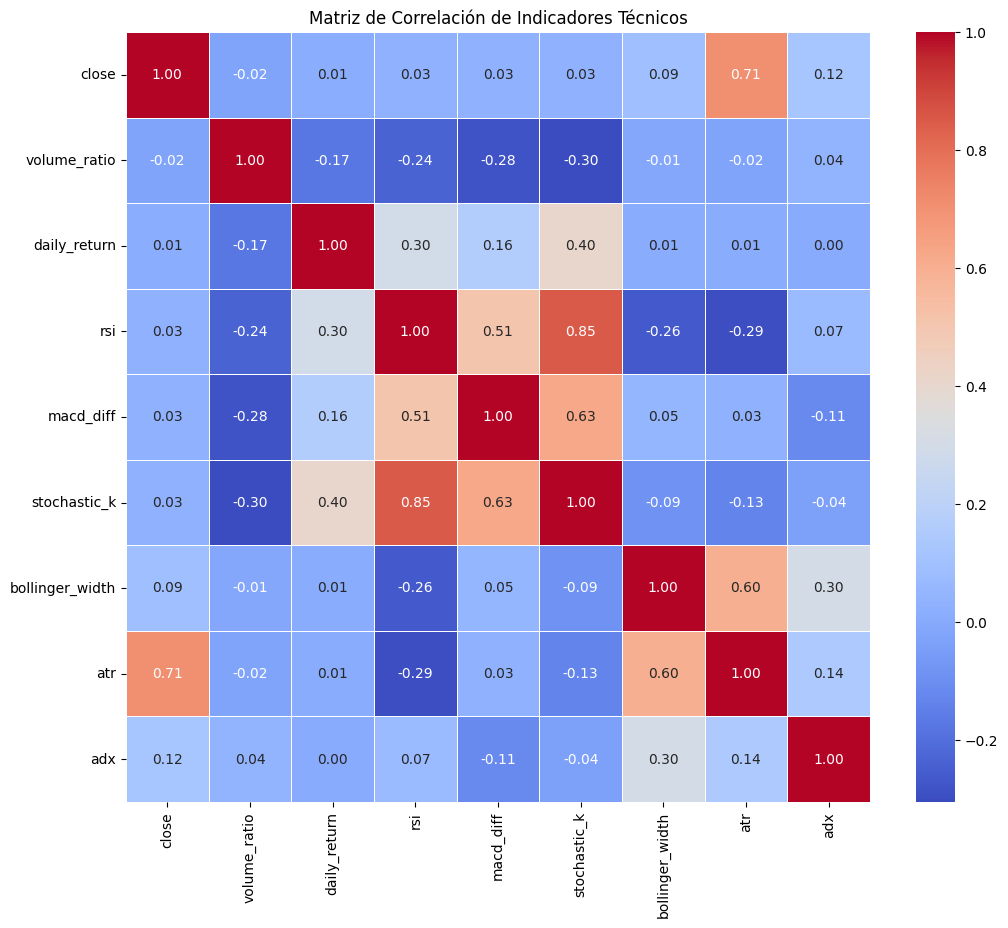

In [27]:

features = [
    'close', 
    'volume_ratio',
    'daily_return', 
    'rsi', 
    'macd_diff', 
    'stochastic_k', 
    'bollinger_width', 
    'atr', 
    'adx'
]

features_existentes = [feat for feat in features if feat in df_voo.columns]

correlation_matrix = df_voo[features_existentes].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación de Indicadores Técnicos')
plt.show()

BAJARAR HACER ANALISIS ESTADISTICO CON SCIPY